# Ponizej krotki opis co przetestowalem do tej pory z algorytmow ML  
Na ta chwile opieram sie na Estra Trees -> dal mi najwyzsza dokladnosc jesli chodzi o accuracy.
W sekcji z treningiem modelu wzialem juz pod uwage, ze score jest liczony inaczej niz accuracy, 
a mianowicie log_loss, co zmienia troche postac rzeczy.

# Random Forest
wszystkie probki treningowe - bez tuningu  
testowe accuracy: 0.9817191330128261  
treningowe time: 44.32341456413269   ---   accuracy: 0.9991453923282256  

wszystkie - max_depth= 70, n_estimators= 100  
testowe: 0.9848913804199887  
treningowe: time: 469.39809942245483   ---   accuracy: 0.9999982415480004  

# Extra Trees
wszystkie probki treningowe - bez tuningu  
testowe accuracy: 0.9822326009966906  
treningowe time: 19.31137776374817   ---   accuracy: 1.0  

wszystkie - 'max_depth': None, 'n_estimators': 100   
testowe: 0.9837343190042941  
treningowe: time: 184.10754990577698   ---   1.0  

# Ada Boost
wszystkie probki treningowe - bez tuningu  
testowe accuracy: 0.4523828783045709  
treningowe time: 174.7924304008484   ---   0.4537878814522 

wszystkie - ??????  
testowe: ??????  
treningowe: time: ??????   ---   accuracy: ??????

# eXtreme Gradient Boosting
wszystkie probki treningowe - bez tuningu  
testowe accuracy: 0.6213947337879517   
treningowe time: 1652.873502254486   ---   0.622957997615539 

wszystkie - ??????  
testowe: ??????  
treningowe: time: ??????   ---   accuracy: ??????

# Gradient Boosting
wszystkie probki treningowe - bez tuningu  
testowe accuracy: 0.6797894077885356   
treningowe time: 3958.553186416626   ---   0.6825616073658037

wszystkie - ??????  
testowe: ??????  
treningowe: time: ??????   ---   accuracy: ??????

In [1]:
import warnings
import time
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import colors as mcolors
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import pandas as pd
import sklearn as sk
from xgboost import XGBClassifier
from sklearn.preprocessing.imputation import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import IsolationForest
import plotly.offline as py
import time
from sklearn.metrics import accuracy_score
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

# Wstepne przetwarzanie danych
Z racji, ze jest okolo 19GB danych testowych musialem podzielic je na mniejsze party 
(moje 32GB RAMu nie sa w stanie uciagnac wszystkiego jesli sie uwzgledni prace pythona,
ktory robi przewaznie kopie DataFramow do pamieci).

In [ ]:
dataset = pd.read_csv("C:\\Users\\Amadeusz\\Downloads\\all\\test_set.csv", 
                      dtype={"object_id":np.int64, "mjd":np.float64, "passband":np.int64,
                             "flux":np.float64, "flux_err":np.float64, "detected":np.int64})
print("Dataset loaded")

Podzial na 10 partow (text_n_part.csv)

In [ ]:
x = list(set(dataset["object_id"]))
n_parts = 10
dlugosc =  np.int(np.ceil(len(x)/n_parts))
for i, n in zip(range(0, len(x), dlugosc), range(1, 11)):
    start = time.time()
    dataset[dataset["object_id"].isin(x[i:i+dlugosc])].to_csv("..\\test_{}.csv".format(n))
    end = time.time()
    print("test_{}.csv saved - elapsed time: {}".format(n, end-start))
%xdel dataset
%xdel x

# Modele ML i statystyczne
Ogolnie czesc, ktora laduje modele z dysku o ile je mamy zapisane.
Jezeli nie, to na podstawie danych treningowych uzcy model i zapisuje na dysk.

Zawarty jest tez tutaj model wykrywania outlayers (wartosci odstajacych), w naszym przypadku novelty.
Pozniej bedzie potrzebny do klasyfikacji probek, ktore nie pasuja do schematu treningowego 
i nie powinny miec zadnej z wczesniejszych class/labels.

C:\Users\Amadeusz\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.



Dataset do not has any column with empty value.
after transformation: 1.6545734405517578
Prediction model saved.
after fit: 69.97481679916382
Outlayer estimator model saved.


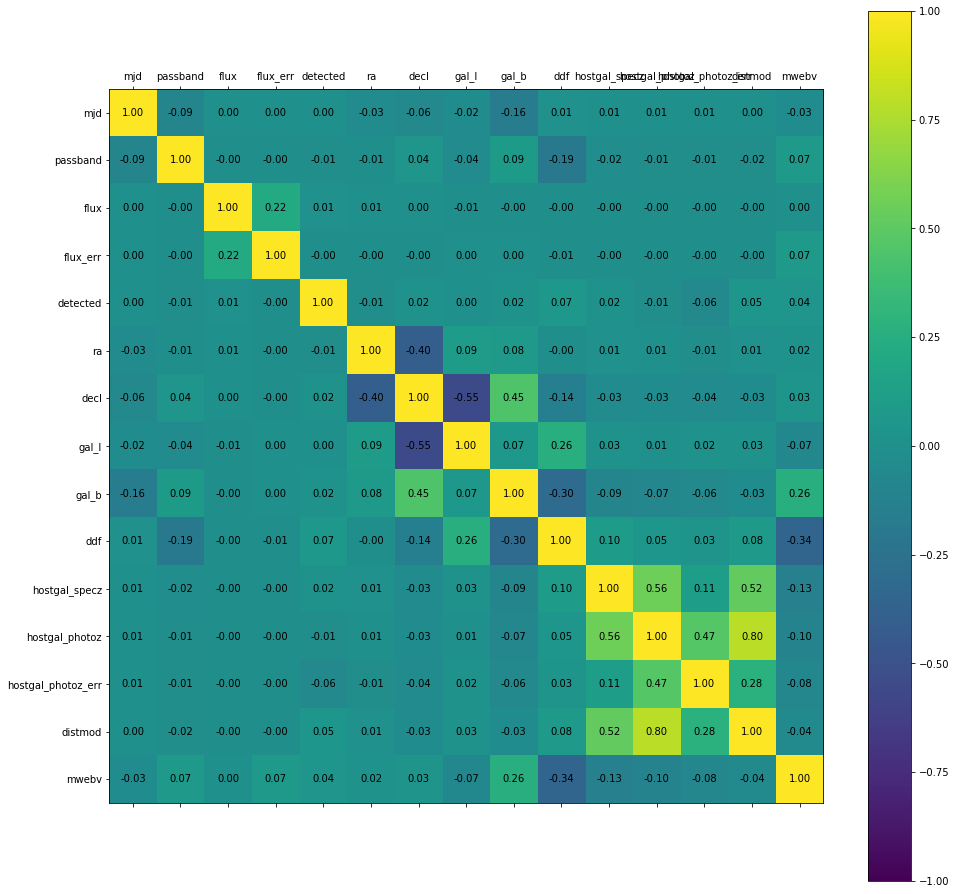

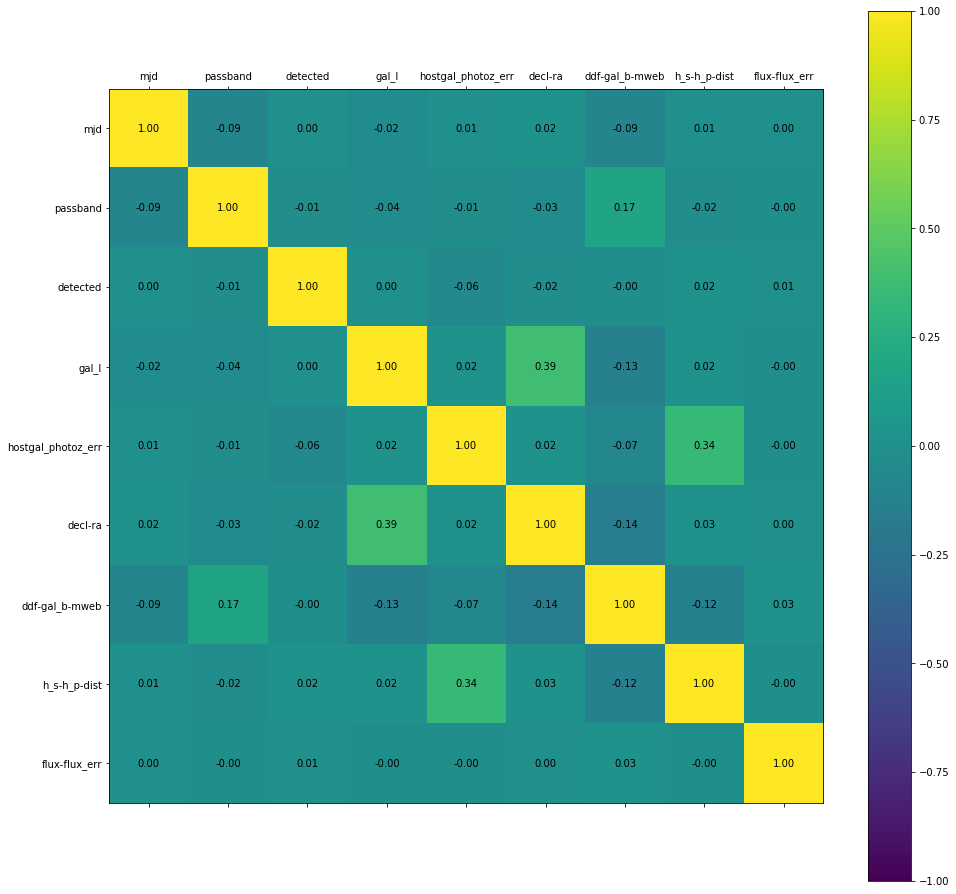

In [2]:
import pickle
from sklearn.metrics import log_loss
try:
    # load the model from disk
    filename = '..\\ET_model_log_loss.sav'
    et = pickle.load(open(filename, 'rb'))
    print("Prediction model loaded.")
    
    # load the model from disk IsolationForest
    filename = '..\\ISF.sav'
    isf = pickle.load(open(filename, 'rb'))
    print("Outlayer model loaded")
    
#     # load the model from disk LocalOutlayerFactor
#     filename = '..\\LOF.sav'
#     lof = pickle.load(open(filename, 'rb'))
#     print("Outlayer model saved")
    
except FileNotFoundError as e:
    # load data ... (to be described)
    dataset = pd.read_csv("C:\\Users\\Amadeusz\\Downloads\\all\\training_set.csv")
    # load metadata, ... (to be described)
    meta_dataset = pd.read_csv('C:\\Users\\Amadeusz\\Downloads\\all\\training_set_metadata.csv')
    column_names = {6: "class_6", 15: "class_15", 16: "class_16", 42: "class_42", 52: "class_52", 53: "class_53",
                    62: "class_62", 64: "class_64", 65: "class_65", 67: "class_67", 88: "class_88", 90: "class_90",
                    92: "class_92", 95: "class_95"}
    # change labels according to sample submission example
    meta_dataset["target"] = list(map(lambda name: column_names[name], meta_dataset["target"]))
    # use imputer to search for NaN values and compute mean() values instead of NaN (column vise)
    mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    mean_imputer = mean_imputer.fit(meta_dataset.iloc[:,:-1]) # without last target column (imputer does not recognize string data)
    imputed_meta_dataset = mean_imputer.transform(meta_dataset.iloc[:,:-1].values)
    imputed_meta_dataset = pd.DataFrame(data=imputed_meta_dataset, columns=meta_dataset.iloc[:,:-1].columns.values)
    imputed_meta_dataset["target"] = meta_dataset.iloc[:,-1] # add last target column to imputed meta dataset
    # change object_id and ddf values back to int() ... imputer interprets all values as float()
    imputed_meta_dataset["object_id"] = list(map(lambda val: int(val), imputed_meta_dataset["object_id"]))
    imputed_meta_dataset["ddf"] = list(map(lambda val: int(val), imputed_meta_dataset["ddf"]))
    # merges two datasets, merge by group_id -> common key in both DataFrames
    training_dataset = pd.merge(dataset, imputed_meta_dataset)
    # check if training_dataset consists of any empty values
    columns_missing = [col for col in training_dataset.columns if training_dataset[col].isnull().any()]
    if columns_missing:
        print("Dataset has missing values in the following columns:\n{}".format(columns_missing))
    else:
        print("Dataset do not has any column with empty value.")
    # split data into training and test datasets (X and Y) ... data is randomly chosen
    test_size = 0.2
    seed = 7
    # description
    # train_test_split(X,Y,test_size,random_state)
    X_train, X_test, Y_train, Y_test = train_test_split(training_dataset.iloc[:,:-1], training_dataset.iloc[:,-1], 
                                                        test_size=test_size, random_state=seed)
    X_train = pd.DataFrame(data=X_train, columns=training_dataset.columns.values.tolist()[:-1])
    X_test = pd.DataFrame(data=X_test, columns=training_dataset.columns.values.tolist()[:-1])
    
    
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    #PCA part
    from sklearn.decomposition import PCA
    #plot correlation matrix between columns (features)
    correlation = training_dataset.iloc[:,1:-1].corr()
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlation, vmin=-1, vmax=1, interpolation='none')
    ticks = [i for i in range(training_dataset.iloc[:,1:-1].shape[1])]
    ticklabels = training_dataset.iloc[:,1:-1].columns.values.tolist()
    plt.xticks(ticks, ticklabels)
    plt.yticks(ticks, ticklabels)
    ax.axis('image')
    # Text on the plot
    for y, row in enumerate(correlation.values):
        for x, val in enumerate(row):
            ax.text(x, y, format(val, '.2f'), color='black', ha='center', va='center')   
    fig.colorbar(cax, )
    fig.savefig('before_PCA_correlation_matrix.pdf')
    
    # scaling training dataset training_dataset.iloc[:,:-1]
    start = time.time()
    scaler = StandardScaler()
#     X_transformed = scaler.fit_transform(X_train.iloc[:,1:].values)
    X_transformed = scaler.fit_transform(training_dataset.iloc[:,1:-1].values)
#     X_transformed = pd.DataFrame(X_transformed, columns=X_train.iloc[:,1:].columns.values.tolist())
    X_transformed = pd.DataFrame(X_transformed, columns=training_dataset.iloc[:,1:-1].columns.values.tolist())
    end = time.time()
    print("after transformation: {}".format(end-start))
    # reduce dimentionality ['decl', 'ra']
    reduce = PCA(n_components=1)
    reduced = reduce.fit_transform(X_transformed[['decl', 'ra']])
    reduced = pd.DataFrame(data=reduced, columns=['decl-ra'])
    X_transformed = X_transformed.drop(['decl', 'ra'], axis=1)
    X_transformed[['decl-ra']] = reduced
    # reduce dimentionality ['ddf', 'gal_b', 'mwebv']
    reduce = PCA(n_components=1)
    reduced = reduce.fit_transform(X_transformed[['ddf', 'gal_b', 'mwebv']])
    reduced = pd.DataFrame(data=reduced, columns=['ddf-gal_b-mweb'])
    X_transformed = X_transformed.drop(['ddf', 'gal_b', 'mwebv'], axis=1)
    X_transformed[['ddf-gal_b-mweb']] = reduced
    # reduce dimentionality ['hostgal_specz', 'hostgal_photoz', 'distmod']
    reduce = PCA(n_components=1)
    reduced = reduce.fit_transform(X_transformed[['hostgal_specz', 'hostgal_photoz', 'distmod']])
    reduced = pd.DataFrame(data=reduced, columns=['h_s-h_p-dist'])
    X_transformed = X_transformed.drop(['hostgal_specz', 'hostgal_photoz', 'distmod'], axis=1)
    X_transformed[['h_s-h_p-dist']] = reduced
    # reduce dimentionality ['flux_err', 'flux']
    reduce = PCA(n_components=1)
    reduced = reduce.fit_transform(X_transformed[['flux_err', 'flux']])
    reduced = pd.DataFrame(data=reduced, columns=['flux-flux_err'])
    X_transformed = X_transformed.drop(['flux_err', 'flux'], axis=1)
    X_transformed[['flux-flux_err']] = reduced
    %xdel reduced
    # correlation plot after PCA
    correlation = X_transformed.corr()
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlation, vmin=-1, vmax=1, interpolation='none')
    ticks = [i for i in range(X_transformed.shape[1])]
    ticklabels = X_transformed.columns.values.tolist()
    plt.xticks(ticks, ticklabels)
    plt.yticks(ticks, ticklabels)
    ax.axis('image')
    # Text on the plot
    for y, row in enumerate(correlation.values):
        for x, val in enumerate(row):
            ax.text(x, y, format(val, '.2f'), color='black', ha='center', va='center')   
    fig.colorbar(cax, )
    fig.savefig('after_PCA_correlation_plot.pdf')
    
#     # scaling test dataset
#     start = time.time()
#     scaler = StandardScaler()
#     X__test_transformed = scaler.fit_transform(X_test.iloc[:,1:].values)
#     X__test_transformed = pd.DataFrame(X__test_transformed, columns=X_test.iloc[:,1:].columns.values.tolist())
#     end = time.time()
#     print("after transformation: {}".format(end-start))
#     # reduce dimentionality ['decl', 'ra']
#     reduce = PCA(n_components=1)
#     reduced = reduce.fit_transform(X__test_transformed[['decl', 'ra']])
#     reduced = pd.DataFrame(data=reduced, columns=['decl-ra'])
#     X__test_transformed = X__test_transformed.drop(['decl', 'ra'], axis=1)
#     X__test_transformed[['decl-ra']] = reduced
#     #  reduce dimentionality ['ddf', 'gal_b', 'mwebv']
#     reduce = PCA(n_components=1)
#     reduced = reduce.fit_transform(X__test_transformed[['ddf', 'gal_b', 'mwebv']])
#     reduced = pd.DataFrame(data=reduced, columns=['ddf-gal_b-mweb'])
#     X__test_transformed = X__test_transformed.drop(['ddf', 'gal_b', 'mwebv'], axis=1)
#     X__test_transformed[['ddf-gal_b-mweb']] = reduced
#     # reduce dimentionality ['hostgal_specz', 'hostgal_photoz', 'distmod']
#     reduce = PCA(n_components=1)
#     reduced = reduce.fit_transform(X__test_transformed[['hostgal_specz', 'hostgal_photoz', 'distmod']])
#     reduced = pd.DataFrame(data=reduced, columns=['h_s-h_p-dist'])
#     X__test_transformed = X__test_transformed.drop(['hostgal_specz', 'hostgal_photoz', 'distmod'], axis=1)
#     X__test_transformed[['h_s-h_p-dist']] = reduced
#     # reduce dimentionality ['flux_err', 'flux']
#     reduce = PCA(n_components=1)
#     reduced = reduce.fit_transform(X__test_transformed[['flux_err', 'flux']])
#     reduced = pd.DataFrame(data=reduced, columns=['flux-flux_err'])
#     X__test_transformed = X__test_transformed.drop(['flux_err', 'flux'], axis=1)
#     X__test_transformed[['flux-flux_err']] = reduced
    
    start = time.time()
    et = ExtraTreesClassifier(n_estimators=100)
    # .iloc[:,1:].values (removes object_id zolumn from computing)
#     et.fit(X_transformed.values, Y_train)
    et.fit(X_transformed.values, training_dataset.iloc[:,-1])
    end = time.time()
#     # accuracy score is not valid here ... accuracy means if we predict label correctly it is very good,
#     # but not enough big predictions for other labels are ignored
#     print("Extra Trees Elapsed Training time: {}   ---   Training accuracy score: {}".format(end - start, et.score(X_transformed.values, Y_train)))
#     start = time.time()
#     predictions = et.predict(X__test_transformed.values)
#     end = time.time()
#     print("Extra Trees Elapsed Test prediction time: {}   ---   Testing accuracy score: {}".format(end - start, accuracy_score(Y_test, predictions)))
#     # compute predictions for each class for each row (sample)
#     start = time.time()
#     predicted_et = pd.DataFrame(et.predict_proba(X__test_transformed.values), columns=et.classes_)
#     end = time.time()
#     print("Predict_proba computed in: {}".format(end-start))
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#     # train model and show score
#     start = time.time()
#     et = ExtraTreesClassifier(n_estimators=100)
#     # .iloc[:,1:].values (removes object_id column from computing)
#     et.fit(X_train.iloc[:,1:].values, Y_train)
#     end = time.time()
#     # accuracy score is not valid here ... accuracy means if we predict label correctly it is very good,
#     # but not enough big predictions for other labels are ignored
#     print("Extra Trees Elapsed Training time: {}   ---   Training accuracy score: {}".format(end - start, et.score(X_train.iloc[:,1:].values, Y_train)))
#     start = time.time()
#     predictions = et.predict(X_test.iloc[:,1:].values)
#     end = time.time()
#     print("Extra Trees Elapsed Test prediction time: {}   ---   Testing accuracy score: {}".format(end - start, accuracy_score(Y_test, predictions)))
#     # compute predictions for each class for each row (sample)
#     start = time.time()
#     predicted_et = pd.DataFrame(et.predict_proba(X_test.iloc[:,1:].values), columns=et.classes_)
#     end = time.time()
#     print("Predict_proba computed in: {}".format(end-start))
    
    
#     from sklearn.metrics import log_loss
#     loss = log_loss(y_true=Y_test, y_pred=predicted_et.values, labels=predicted_et.columns.values.tolist())
#     print("Log_loss: {}".format(loss))
#     print("Precision: {}".format(np.exp(-loss)))

    # save model
    filename = '..\\ET_model_log_loss.sav'
    pickle.dump(et, open(filename, 'wb'))
    print("Prediction model saved.")
    
    # fit novelty detector model IsolationForest (~100 seconds computing time)
    start = time.time()
    isf = IsolationForest()
#     isf.fit(np.ascontiguousarray(X_train.iloc[:,1:].values))
    isf.fit(np.ascontiguousarray(X_transformed.values)) # PCA part
    end = time.time()
    print("after fit: {}".format(end-start))
    
    # save isf model
    filename = '..\\ISF.sav'
    pickle.dump(isf, open(filename, 'wb'))
    print("Outlayer estimator model saved.")
    
#     # scaling training data only for LocalOutlayerFactor(~1 second computing time)
#     start = time.time()
#     scaler = StandardScaler()
#     X_transformed = scaler.fit_transform(X_train.iloc[:,1:].values)
#     end = time.time()
#     print("after transformation: {}".format(end-start))
    
#     # fit novelty detector model LocalOutlayerFactor (~1800 seconds computing time)
#     start = time.time()
#     lof = LocalOutlierFactor(novelty=True)
#     lof.fit(np.ascontiguousarray(X_transformed))
#     end = time.time()
#     print("after fit: {}".format(end-start))
    
#     # save isf model
#     filename = '..\\LOF.sav'
#     pickle.dump(lof, open(filename, 'wb'))
#     print("Outlayer estimator model saved.")

https://www.kaggle.com/c/predict-closed-questions-on-stack-overflow/discussion/2499  
Wyjasnienie odnosnie log loss chociaz raczej nie do konca trafne jesli chodzi o ostatnie zdania (log5....itp).
Log_loss powinien schodzic jak najblizej wartosci zerowej wtedy prawdopodobienstwo, ze mamy dobre wyniki jest bliskie jedynki.

# Predict part
Klasyfikacja probek, plus utworzenie nowej klasy w zaleznosci czy probka jest odstajaca czy nie.

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
def predictions(predicted_dataframe, object_id):
    """Search rows with low prediction accuracy, if none of class was predicted higher then 0.6, classify as outlayer.
    Add class_99 column for outlayers"""
    columns = predicted_dataframe.columns.values.tolist()
    start = time.time()
    class_99 = np.any(predicted_dataframe[predicted_dataframe[columns] <= 0.6].apply(np.isnan), axis=1).apply(np.logical_not).apply(np.int)
    predicted_dataframe["class_99"] = class_99
    end = time.time()
    print("After search, elapsed time: {}".format(end-start))
    predicted_dataframe.insert(0,"object_id",object_id)
    
def predictions_ISF(predicted_dataframe, object_id, data, isf):
    """Use IsolationForest to classify if there is an outlayer, unseen label/class"""
    columns = predicted_dataframe.columns.values.tolist()
    n_samples = 1000000
    l_data = len(data)
    
    start = time.time()
    class_99 =  np.array([])
    for i in range(n_samples, l_data, n_samples): # IsolationForest cannot handle big datasets (32GB of RAM allocation is not enough)
        #http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest.predict
        class_99 = np.append(class_99, isf.predict(data[i-n_samples:i])) # IsolationForest predicts if sample is outlayer (-1 or inlayer 1)
        print("Batch {} of {}, elapsed time: {}".format(i/n_samples, round(l_data/n_samples), time.time()-start))
    class_99 = np.append(class_99, isf.predict(data[l_data-l_data%n_samples:]))
    class_99[class_99 == 1] = 0 # change inlayers to 0 value
    predicted_dataframe["class_99"] = class_99 # append predictions with new class column
    end = time.time()
    
    print("After search, elapsed time: {}".format(end-start))
    predicted_dataframe.insert(0,"object_id",object_id)
    
%xdel dataset
%xdel meta_dataset
%xdel imputed_meta_dataset
%xdel training_dataset
%xdel X_train
%xdel X_test
%xdel Y_train
%xdel Y_test
print("After memory relocation")

meta_dataset = pd.read_csv('C:\\Users\\Amadeusz\\Downloads\\all\\test_set_metadata.csv')
mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
mean_imputer = mean_imputer.fit(meta_dataset)
imputed_meta_dataset = mean_imputer.transform(meta_dataset.values)
imputed_meta_dataset = pd.DataFrame(data=imputed_meta_dataset, columns=meta_dataset.columns.values)
# change object_id and ddf values back to int() ... imputer interprets all values as float()
imputed_meta_dataset["object_id"] = list(map(lambda val: int(val), imputed_meta_dataset["object_id"]))
imputed_meta_dataset["ddf"] = list(map(lambda val: int(val), imputed_meta_dataset["ddf"]))

for i in range(1,11):
    dataset = pd.read_csv("..\\test_{}.csv".format(i), index_col=0)
    dataset_merged = pd.merge(dataset, imputed_meta_dataset, on="object_id")
    %xdel dataset
    object_id = dataset_merged["object_id"]
    
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# PCA
    # scaling 
    start = time.time()
    scaler = StandardScaler()
    dataset_transformed = scaler.fit_transform(dataset_merged.iloc[:,1:].values)
    dataset_transformed = pd.DataFrame(dataset_transformed, columns=dataset_merged.iloc[:,1:].columns.values.tolist())
    %xdel dataset_merged
    end = time.time()
    print("after transformation: {}".format(end-start))
    # reduce dimentionality ['decl', 'ra']
    reduce = PCA(n_components=1)
    reduced = reduce.fit_transform(dataset_transformed[['decl', 'ra']])
    reduced = pd.DataFrame(data=reduced, columns=['decl-ra'])
    dataset_transformed = dataset_transformed.drop(['decl', 'ra'], axis=1)
    dataset_transformed[['decl-ra']] = reduced
    # reduce dimentionality ['ddf', 'gal_b', 'mwebv']
    reduce = PCA(n_components=1)
    reduced = reduce.fit_transform(dataset_transformed[['ddf', 'gal_b', 'mwebv']])
    reduced = pd.DataFrame(data=reduced, columns=['ddf-gal_b-mweb'])
    dataset_transformed = dataset_transformed.drop(['ddf', 'gal_b', 'mwebv'], axis=1)
    dataset_transformed[['ddf-gal_b-mweb']] = reduced
    # reduce dimentionality ['hostgal_specz', 'hostgal_photoz', 'distmod']
    reduce = PCA(n_components=1)
    reduced = reduce.fit_transform(dataset_transformed[['hostgal_specz', 'hostgal_photoz', 'distmod']])
    reduced = pd.DataFrame(data=reduced, columns=['h_s-h_p-dist'])
    dataset_transformed = dataset_transformed.drop(['hostgal_specz', 'hostgal_photoz', 'distmod'], axis=1)
    dataset_transformed[['h_s-h_p-dist']] = reduced
    # reduce dimentionality ['flux_err', 'flux']
    reduce = PCA(n_components=1)
    reduced = reduce.fit_transform(dataset_transformed[['flux_err', 'flux']])
    reduced = pd.DataFrame(data=reduced, columns=['flux-flux_err'])
    dataset_transformed = dataset_transformed.drop(['flux_err', 'flux'], axis=1)
    dataset_transformed[['flux-flux_err']] = reduced

    
    start = time.time()
    predicted_et = pd.DataFrame(et.predict_proba(dataset_transformed.values), columns=et.classes_)
    end = time.time()
    print("Part {} Predict Elapsed time: {}".format(i, end-start))
    
    # IsolationForest method
    predictions_ISF(predicted_et, object_id, dataset_transformed.values, isf)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
#     start = time.time()
#     predicted_et = pd.DataFrame(et.predict_proba(dataset_merged.iloc[:,1:].values), columns=et.classes_)
#     end = time.time()
#     print("Part {} Predict Elapsed time: {}".format(i, end-start))
    
#     # IsolationForest method
#     predictions_ISF(predicted_et, object_id, dataset_merged.iloc[:,1:].values, isf)
    # Manual method
#     predictions(predicted_et, object_id)
    
    start = time.time()
    predicted_et.to_csv("..\\predicted_et_n_{}.csv".format(i))
    end = time.time()
    print("Part {} Save to CSV Elapsed time: {}".format(i, end-start))
    %xdel dataset_merged
    %xdel predicted_et
    %xdel dataset_transformed

NameError: name 'dataset' is not defined
NameError: name 'training_dataset' is not defined
NameError: name 'X_train' is not defined
NameError: name 'X_test' is not defined
NameError: name 'Y_train' is not defined
NameError: name 'Y_test' is not defined
After memory relocation
after transformation: 80.92400789260864
Part 1 Predict Elapsed time: 1386.7398672103882
Batch 1.0 of 51, elapsed time: 46.61686587333679
Batch 2.0 of 51, elapsed time: 93.23471689224243
Batch 3.0 of 51, elapsed time: 139.98176074028015
Batch 4.0 of 51, elapsed time: 185.24576997756958
Batch 5.0 of 51, elapsed time: 231.01604175567627
Batch 6.0 of 51, elapsed time: 276.26101088523865
Batch 7.0 of 51, elapsed time: 321.7751975059509
Batch 8.0 of 51, elapsed time: 365.82037901878357
Batch 9.0 of 51, elapsed time: 413.1028995513916
Batch 10.0 of 51, elapsed time: 458.18484711647034
Batch 11.0 of 51, elapsed time: 502.6431152820587
Batch 12.0 of 51, elapsed time: 548.1064188480377
Batch 13.0 of 51, elapsed time: 594.51

Batch 4.0 of 45, elapsed time: 198.23051381111145
Batch 5.0 of 45, elapsed time: 247.5507276058197
Batch 6.0 of 45, elapsed time: 297.09080362319946
Batch 7.0 of 45, elapsed time: 346.6222858428955
Batch 8.0 of 45, elapsed time: 396.4896984100342
Batch 9.0 of 45, elapsed time: 445.3177514076233
Batch 10.0 of 45, elapsed time: 494.9423336982727
Batch 11.0 of 45, elapsed time: 545.0133459568024
Batch 12.0 of 45, elapsed time: 594.9890472888947
Batch 13.0 of 45, elapsed time: 644.2397575378418
Batch 14.0 of 45, elapsed time: 694.2397425174713
Batch 15.0 of 45, elapsed time: 744.1234064102173
Batch 16.0 of 45, elapsed time: 793.8113877773285
Batch 17.0 of 45, elapsed time: 843.8822531700134
Batch 18.0 of 45, elapsed time: 893.6555511951447
Batch 19.0 of 45, elapsed time: 943.2922010421753
Batch 20.0 of 45, elapsed time: 993.8018822669983
Batch 21.0 of 45, elapsed time: 1043.7994751930237
Batch 22.0 of 45, elapsed time: 1094.3851237297058
Batch 23.0 of 45, elapsed time: 1144.4863271713257
B

Batch 22.0 of 45, elapsed time: 1101.020175933838
Batch 23.0 of 45, elapsed time: 1155.3420548439026
Batch 24.0 of 45, elapsed time: 1210.1514163017273
Batch 25.0 of 45, elapsed time: 1264.8701164722443
Batch 26.0 of 45, elapsed time: 1314.4130330085754
Batch 27.0 of 45, elapsed time: 1361.407175540924
Batch 28.0 of 45, elapsed time: 1408.2389035224915
Batch 29.0 of 45, elapsed time: 1455.2397265434265
Batch 30.0 of 45, elapsed time: 1503.282369852066
Batch 31.0 of 45, elapsed time: 1552.0273008346558
Batch 32.0 of 45, elapsed time: 1599.1019451618195
Batch 33.0 of 45, elapsed time: 1648.2332644462585
Batch 34.0 of 45, elapsed time: 1696.8900454044342
Batch 35.0 of 45, elapsed time: 1745.4871892929077
Batch 36.0 of 45, elapsed time: 1794.1682772636414
Batch 37.0 of 45, elapsed time: 1843.1734597682953
Batch 38.0 of 45, elapsed time: 1891.5438618659973
Batch 39.0 of 45, elapsed time: 1940.095775604248
Batch 40.0 of 45, elapsed time: 1988.483803510666
Batch 41.0 of 45, elapsed time: 2037

Batch 39.0 of 45, elapsed time: 1856.0471386909485
Batch 40.0 of 45, elapsed time: 1903.2657239437103
Batch 41.0 of 45, elapsed time: 1950.514654636383
Batch 42.0 of 45, elapsed time: 1997.1876213550568
Batch 43.0 of 45, elapsed time: 2043.9190828800201
Batch 44.0 of 45, elapsed time: 2090.92507314682
After search, elapsed time: 2125.436639070511
Part 10 Save to CSV Elapsed time: 701.1941492557526
NameError: name 'dataset_merged' is not defined


# Grupowanie
Test dataset zawiera kilka probek na dany obiekt, 
z racji tego potrzeba wyestymowac z grupy probek dla obiektu do jakiej klasy nalezy.
Najlepiej dotad sprawdzila sie srednia z prawdopodobienstw dla danych klas.
Nie mam wyniku jeszcze dla sredniej z uwzglednieniem IsolationForest - postaram sie przeprowadzic obliczenia.

In [5]:
# verified faster version (2.5 times faster then slower version version)
# def find_best_row(x):
#     """Finds row with maximum value in each group and returns that row."""
#     maximum = 0
#     return_row = 0
#     for ind, row in x.drop(["object_id"], axis=1).iterrows():
#         r = np.max(row.values)
#         if r > maximum:
#             maximum = r
#             return_row = row
#     return return_row

# def find_best_row(x):
#     """Finds row with maximum value in each group and returns that row."""
# #     s = time.time()
#     maximum = np.max(x.values)
# #     print("After max search, elapsed: {}".format(time.time()-s))
# #     s = time.time()
#     z = x[x[x.columns] == maximum].fillna(0)
# #     print("After fillna, elapsed: {}".format(time.time()-s))
#     return_row = 0
# #     s = time.time()
#     for ind, row in z.iterrows():
#         r = np.max(row.values)
#         if r == maximum:
#             return_row = row
#             break
# #     print("After for loop, elapsed: {}".format(time.time()-s))
#     return return_row  # leave only maximum prediction for row, other fill with zero

# slower version
# def find_best_row(x):
#     """Finds row with maximum value in each group and returns that row."""
#     index = x.drop(["object_id"], axis=1).T.max().idxmax()
#     return x.loc[[index]]

# compute grouped results for each object_id
for i in range(1,11):
    start = time.time()
    dataset = pd.read_csv("..\\predicted_et_n_{}.csv".format(i), index_col=0)
    print("predicted_et loaded, time elapsed: {}".format(time.time()-start))
#     grouped = dataset.groupby(by="object_id").apply(lambda x: find_best_row(x)).reset_index(level=1, drop=True).drop(["object_id"], axis=1)
#     print("Dataset grouped and best row found. time elapsed: {}".format(time.time() - start))
#     grouped = dataset.groupby(by="object_id").apply(lambda x: find_best_row(x.drop(["object_id"], axis=1)))    # returns only best row (for loop)
#     print("Dataset grouped and best row found. time elapsed: {}".format(time.time() - start))
    grouped = dataset.groupby(by="object_id").mean()    # returns mean of grouped rows
    grouped.to_csv("..\\grouped_{}.csv".format(i))
    %xdel grouped
    %xdel dataset
    end = time.time()
    print("Group {} saved. Elapsed time: {}".format(i, end-start))

# merge all parts into one dataset
for i in range(1,11):
    start = time.time()
    if i == 1:
        dataset = pd.read_csv("..\\grouped_{}.csv".format(i), index_col=0)
    else:
        dataset = pd.concat([dataset, pd.read_csv("..\\grouped_{}.csv".format(i), index_col=0)])
    end = time.time()
    print("Group {} added. Elapsed time: {}".format(i, end-start))

dataset.to_csv("..\\LSST_project_prediction_mean_ISF.csv")
%xdel dataset

predicted_et loaded, time elapsed: 136.96681332588196
Group 1 saved. Elapsed time: 155.50196886062622
predicted_et loaded, time elapsed: 114.2794234752655
Group 2 saved. Elapsed time: 132.77944159507751
predicted_et loaded, time elapsed: 114.33836913108826
Group 3 saved. Elapsed time: 132.1105546951294
predicted_et loaded, time elapsed: 118.4224157333374
Group 4 saved. Elapsed time: 136.0341968536377
predicted_et loaded, time elapsed: 118.20037627220154
Group 5 saved. Elapsed time: 135.4812672138214
predicted_et loaded, time elapsed: 123.40528464317322
Group 6 saved. Elapsed time: 141.0255560874939
predicted_et loaded, time elapsed: 123.97477269172668
Group 7 saved. Elapsed time: 141.73155903816223
predicted_et loaded, time elapsed: 126.11838221549988
Group 8 saved. Elapsed time: 144.38404059410095
predicted_et loaded, time elapsed: 130.2644464969635
Group 9 saved. Elapsed time: 148.70302963256836
predicted_et loaded, time elapsed: 128.7367241382599
Group 10 saved. Elapsed time: 148.28